In [1]:
#############################
#          Imports          #
#############################

import os
import sys
import json
import spotipy
import webbrowser
import spotipy.util as util
import numpy as np
from json.decoder import JSONDecodeError
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

In [2]:
#setting up some of the needed objects for Spotify API
username = '22n4jazl2sbg5sksr76pvxsai'
my_client_id = 'bc4909a1581c4a7fae82674e4ef6875f'
my_secret = 'df9efd5f88764003a5bcb434e75d777d'
my_redirect_uri = 'https://www.google.com/'
spotify = spotipy.Spotify()
scope = 'user-library-read'

#User permission
try:
    token = util.prompt_for_user_token(username, scope, my_client_id,
                                       my_secret, redirect_uri = my_redirect_uri)
except:
    token = util.prompt_for_user_token(username)
    
#getting authorization
if token:
    spotify_object = spotipy.Spotify(auth = token)
    print('Successfully authenticated')
else:
    print('Cannot get token for', username)

#saving user as an object
user = spotify_object.current_user()

#obtaining display name and follower count values for printing purposes
displayName = user['display_name']
follower_count = user['followers']['total']
artist_name =  'Frank Ocean'


Successfully authenticated


In [3]:
print(">>> Hello " + displayName + "!")
search_results = spotify_object.search(artist_name, 1, 0, "artist")
artist = search_results['artists']['items'][0]
print('Artist Name: ',artist['name'])
print('Genres:',artist['genres'][0].replace(' ', ', ').replace('hip, hop', 'hip hop'))
print()
artistID = artist['id']

#albums and tracks
trackURIs = []

album_results = spotify_object.artist_albums(artistID)
album_results = album_results['items']

for album in album_results:
    albumID = album['id']
    #extracting tracks
    track_results = spotify_object.album_tracks(albumID)
    track_results = track_results['items']
    #nested iteration to add track uri to master list
    for song in track_results:
        #only appending songs where the artist is the main singer; i.e. first person listed as the artist, not feature
        if (artist_name in song['artists'][0]['name']):
            trackURIs.append(song['uri'])
    
    #if you want to include artists' collaborations and features, uncomment
    #for song in track_results:
        #for song_artist in song['artists']:
            #if song_artist['name'] == artist_name:
                #trackURIs.append(song['uri'])

>>> Hello Pranay Lolabattu!
Artist Name:  Frank Ocean
Genres: hip hop



In [4]:
#With Track URIs, getting song names
#Initializing trackNames list
trackNames = []
for URI in trackURIs:
    track = spotify_object.track(URI)
    trackNames.append(track['name'])

In [5]:
#########################
# Using the Genius API  #
#########################
YOUR_CLIENT_ID = 'OPyv8DqR79Sxu0Esh0kbSPtGlIHU_QYMt9_xHizoJN2hQQvvn4-dqW8hGmkeSw8A'
genius_token = 'IX3cTgRvySWDLcqeJ9Rqqv9UrrPv8STQPr2-Lnc9ncMv8zGA7MY7xJpEQsTMLoVf'
base_url = "http://api.genius.com"
search_url = base_url + "/search"
headers = {'Authorization': 'Bearer ' + genius_token}
def get_song_info(url, list_songs, headers):
    songs = []
    for song in list_songs:
        data = {'q': song}
        response = requests.get(url, params=data, headers=headers)
        json = response.json()
        #initializing song info
        song_info = None
        for hit in json["response"]["hits"]:
            #verifying the search result and its artist is the same as the artist of our choice (i.e. Frank Ocean)
            if hit["result"]["primary_artist"]["name"] == artist_name:
                song_info = hit
                break
        if song_info:
            #verifying that the song exists in Genius. If it exists, adds on to the list.
            songs.append(song_info)
    return songs
songs = get_song_info(search_url, trackNames, headers)

In [6]:
#finding the genius urls for all songs
#initializing the url list
url_dict = {}
genius_url = []
for song in songs:
    url_extension = song['result']['path']
    url = 'https://genius.com' + url_extension
    genius_url.append(url)
    url_dict[song['result']['title']] = url

In [7]:
from bs4 import BeautifulSoup
import re
lyrics_dict = {}

for URL in genius_url:
    page = requests.get(URL)
    html = BeautifulSoup(page.text, "html.parser") # Extract the page's HTML as a string
    # Scrape the song lyrics from the HTML
    lyrics = html.find("div", class_="lyrics").get_text()
    lyrics_dict[URL] = lyrics

In [15]:
english = "a b c d e f g h i j k l m n o p q r s t u v w x y z A B C D E F G H I J K L M N O P Q R S T U V W X Y Z".split()
master_array = np.array([])
master_string = ''
for URL in genius_url:
    pretty = lyrics_dict[URL].replace('\n\n', '').replace('\n', '. ')
    pretty = re.sub(r'\[.*?\]', '', pretty)
    pretty = re.sub(r'\s+', ' ', pretty)
    pretty = pretty.replace('\'', '’')
    master_string += pretty + ' '
    word_list = pretty.replace('\'', '’').lower().split()
    is_english = [word[0] in english for word in word_list]
    word_list = np.array(word_list)
    word_list = word_list[is_english]
    master_array = np.append(master_array, word_list)
master_array

array(['these', 'bitches', 'want', ..., 'good.', 'don’t', 'die'],
      dtype='<U32')

In [16]:
unique, counts = np.unique(master_array, return_counts=True)
word_count = dict(zip(unique, counts))
word_count

{'emotion.': 1,
 'wish': 6,
 'weak': 4,
 'dilated': 1,
 'past': 3,
 'know': 67,
 'night,': 6,
 'have': 20,
 'although': 1,
 'sleepin’': 1,
 'year,': 1,
 'jasmine': 1,
 'bro?.': 1,
 'crown': 1,
 'died,': 1,
 'peaches,': 2,
 'ah-ah-ahhh,': 2,
 'armor.': 1,
 'chip': 1,
 'quick,': 2,
 'facebook': 1,
 'rose': 1,
 'awkward': 1,
 'in.': 2,
 'live.': 2,
 'underneath': 6,
 'swisha).': 1,
 'inviting': 1,
 'rally’s': 1,
 'honors.': 1,
 'jewel.': 1,
 'sides': 8,
 'suite': 1,
 'skating.': 1,
 'gift': 2,
 'channel': 1,
 'hurricane.': 2,
 'no.': 3,
 'all.': 7,
 'low,': 3,
 'mother': 1,
 'risk,': 1,
 'high,': 5,
 'madre,': 1,
 'doom.': 1,
 'rotation': 1,
 'leone).': 2,
 'matt': 1,
 'fighter': 2,
 'umm-': 1,
 'sleet': 1,
 'ghost,': 1,
 'someday': 1,
 'got….': 2,
 'rides.': 2,
 'cowgirl.': 1,
 'next': 1,
 'gump': 1,
 'else.': 3,
 'half': 3,
 'happy': 1,
 'sold': 2,
 'head,': 3,
 'natural': 1,
 'hit': 13,
 'peace': 1,
 'raf': 2,
 'cholo,': 1,
 'circle,': 1,
 'higgs.': 1,
 'realizin’': 1,
 'dishes,': 1,
 

In [17]:
for i in stopwords.words('english'):
    if i in word_count:
        del word_count[i]

In [18]:
#displaying the dictionary in descending order of word counts
word_count_ordered = []
for i in sorted(word_count, key=word_count.get, reverse=True):
    word_count_ordered.append(i + ": " + str(word_count[i]))
#number of different words used
len(word_count_ordered)

2833

In [19]:
word_count_ordered

['i’m: 132',
 'like: 124',
 'got: 104',
 'it’s: 94',
 'don’t: 86',
 'me.: 76',
 'know: 67',
 'you.: 59',
 'you’re: 49',
 'love: 49',
 'could: 48',
 'get: 48',
 'can’t: 47',
 'see: 44',
 'ain’t: 42',
 'feel: 40',
 'that’s: 37',
 'think: 35',
 'working: 31',
 'fuck: 30',
 'you,: 29',
 'keep: 28',
 'up.: 28',
 'thinkin’: 28',
 'life.: 27',
 'make: 27',
 'yeah.: 26',
 'every: 26',
 'way: 25',
 'run: 25',
 'back: 24',
 'oh,: 23',
 'i’ve: 23',
 'showed: 22',
 'me,: 22',
 'i’ll: 22',
 'sweet: 22',
 'one: 22',
 'it.: 22',
 'bout: 22',
 'time: 21',
 'let: 21',
 'million: 20',
 'day: 20',
 'good: 20',
 'want: 19',
 'never: 19',
 'still: 19',
 'around: 19',
 'go: 19',
 'shit.: 18',
 'nothing: 18',
 'now.: 18',
 'dollar: 18',
 'need: 18',
 'new: 18',
 'wanna: 18',
 'fucked: 18',
 'night: 18',
 'pretty: 18',
 'love.: 18',
 'say: 18',
 'we’re: 17',
 'cause: 17',
 'real: 17',
 'solo.: 17',
 'i,: 17',
 'no,: 16',
 'good.: 16',
 'novacane,: 16',
 'many: 15',
 'couldn’t: 15',
 'there’s: 15',
 'life: 15'

In [20]:
#############################
#  Named Entity Recognition #
#############################
#using stanford's NER tool
from nltk.tag.stanford import StanfordNERTagger
from nltk.tokenize import word_tokenize
st = StanfordNERTagger('/Users/Pranay.lolabattu/Downloads/stanford-ner-2018-02-27/stanford-ner-2018-02-27/classifiers/english.all.3class.distsim.crf.ser.gz',
               '/Users/Pranay.lolabattu/Downloads/stanford-ner-2018-02-27/stanford-ner-2018-02-27/stanford-ner.jar', encoding='utf-8')
pretty = lyrics_dict[genius_url[0]].replace('\n\n', '').replace('\n', '. ')
pretty = re.sub(r'\[.*?\]', '', pretty)
pretty = re.sub(r'\s+', ' ', pretty)
print(st.tag(word_tokenize(pretty)))
pretty

[('.', 'O'), ('These', 'O'), ('bitches', 'O'), ('want', 'O'), ('Nikes', 'O'), ('.', 'O'), ('They', 'O'), ('looking', 'O'), ('for', 'O'), ('a', 'O'), ('check', 'O'), ('.', 'O'), ('Tell', 'O'), ("'em", 'O'), ('it', 'O'), ('ain', 'O'), ('’', 'O'), ('t', 'O'), ('likely', 'O'), ('.', 'O'), ('Said', 'O'), ('she', 'O'), ('need', 'O'), ('a', 'O'), ('ring', 'O'), ('like', 'O'), ('Carmelo', 'O'), ('.', 'O'), ('It', 'O'), ('must', 'O'), ('be', 'O'), ('on', 'O'), ('that', 'O'), ('white', 'O'), ('like', 'O'), ('Othello', 'O'), ('.', 'O'), ('All', 'O'), ('you', 'O'), ('want', 'O'), ('is', 'O'), ('Nikes', 'O'), ('.', 'O'), ('But', 'O'), ('the', 'O'), ('real', 'O'), ('ones', 'O'), ('.', 'O'), ('Just', 'O'), ('like', 'O'), ('you', 'O'), ('.', 'O'), ('Just', 'O'), ('like', 'O'), ('me', 'O'), ('.', 'O'), ('I', 'O'), ('do', 'O'), ("n't", 'O'), ('play', 'O'), (',', 'O'), ('I', 'O'), ('do', 'O'), ("n't", 'O'), ('make', 'O'), ('time', 'O'), ('.', 'O'), ('But', 'O'), ('if', 'O'), ('you', 'O'), ('need', 'O'), 

". These bitches want Nikes. They looking for a check. Tell 'em it ain’t likely. Said she need a ring like Carmelo. It must be on that white like Othello. All you want is Nikes. But the real ones. Just like you. Just like me. I don't play, I don't make time. But if you need dick I got you. And I yam from the line. Pour up for A$AP. RIP Pimp C. RIP Trayvon, that nigga look just like me. Woo, fuckin’ buzzin', woo!. That my little cousin, he got a little trade. His girl keep the scales, a little mermaid. We out by the pool, some little mermaids. Me and them gel. Like twigs with them bangs. Now that's a real mermaid. You been holding your breath. Weighted down. Punk madre, punk papa. He don't care for me. But he cares for me. And that's good enough. We don't talk much or nothin'. But when we talkin' about something. We have good discussion. I met his friends last week. Feels like they’re up to something. That’s good for us. We'll let you guys prophesize. We’ll let you guys prophesize. We g

In [27]:
#using st.tag to create list with tupled categorization for entities
tag_lyrics = st.tag(master_string.split())
#filtering out the non named entities
named_e = [t for t in tag_lyrics if t[1] != 'O']
named_e

[('Earth', 'LOCATION'),
 ('Earth', 'LOCATION'),
 ('Colorado', 'LOCATION'),
 ('Earth', 'LOCATION'),
 ('Congo', 'LOCATION'),
 ('Boswell', 'PERSON'),
 ('Percy', 'PERSON'),
 ('Facebook', 'ORGANIZATION'),
 ('Texas', 'LOCATION'),
 ('Punani', 'LOCATION'),
 ('Tyler', 'PERSON'),
 ('Jay', 'PERSON'),
 ('Twins', 'ORGANIZATION'),
 ('Lance', 'PERSON'),
 ('know.', 'PERSON'),
 ('Clark', 'PERSON'),
 ('Sierra', 'LOCATION'),
 ('Leone).', 'LOCATION'),
 ('Sierra', 'ORGANIZATION'),
 ('Lennon', 'PERSON'),
 ('Ladera', 'LOCATION'),
 ('Raggy', 'PERSON'),
 ('Anns', 'PERSON'),
 ('Mammy', 'PERSON'),
 ('Hermes', 'ORGANIZATION'),
 ('Jones', 'PERSON'),
 ('Arkansas', 'LOCATION'),
 ('Samson', 'PERSON'),
 ('Earth', 'LOCATION'),
 ('Benjamin', 'PERSON'),
 ('Forrest', 'PERSON'),
 ('Forrest', 'PERSON'),
 ('Des', 'LOCATION'),
 ('Garcons.', 'LOCATION'),
 ('Me.', 'LOCATION'),
 ('Florida.', 'LOCATION'),
 ('Impietas', 'ORGANIZATION'),
 ('Mitsubishi', 'ORGANIZATION'),
 ('Patagonia', 'LOCATION'),
 ('L.A.', 'LOCATION'),
 ('Tiffany'

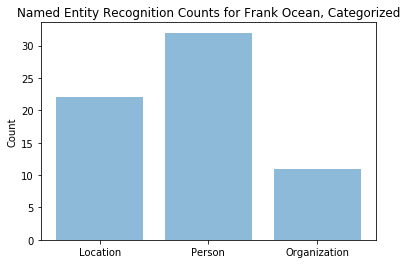

In [24]:
#counting the number of entities
list_named_count = [len([t for t in named_e if t[1] == 'LOCATION']), 
                   len([t for t in named_e if t[1] == 'PERSON']),
                   len([t for t in named_e if t[1] == 'ORGANIZATION'])]
list_named_names = ['Location', 'Person', 'Organization']
y_pos = np.arange(len(list_named_names))

plt.bar(y_pos, list_named_count, align = 'center', alpha=0.5)
plt.xticks(y_pos, list_named_names)
plt.ylabel('Count')
plt.title('Named Entity Recognition Counts for Frank Ocean, Categorized')
plt.show()

In [26]:
import sklearn